In [1]:
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Input, Bidirectional,TimeDistributed

import pickle

import os

from collections import Counter
from scipy.sparse import hstack

from prettytable import PrettyTable
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
root_path = '/content/gdrive/My Drive/IRE_Major_Project/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
data = pd.read_csv(root_path+'preprocessed.csv')

In [4]:
data.head()

,id,tweet,new_tweet,user_mentions,n_hash_tags,n_urls,n_emojis,subtask_a,subtask_b,subtask_c,original_tweet_length,new_tweet_length
0,86426,@USER She should ask a few native Americans wh...,she ask native americans their take be,1,0,0,0,OFF,UNT,NaN,14,7
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,go home you drink maga trump2020,3,2,1,1,OFF,TIN,IND,11,6
2,16820,Amazon is investigating Chinese employees who ...,amazon investigate chinese employees sell inte...,0,5,1,0,NOT,NaN,NaN,27,19
3,62688,"@USER Someone should'veTaken"" this piece of sh...",someone should vetaken piece shit volcano,1,0,0,1,OFF,UNT,NaN,11,6
4,43605,@USER @USER Obama wanted liberals &amp; illega...,obama want liberals amp illegals move red state,2,0,0,0,NOT,NaN,NaN,12,8


In [0]:
data.drop(columns = ['subtask_b' , 'subtask_c'] , inplace = True)

# Splitting Data: Train and Test


In [6]:
data['subtask_a'].value_counts()

NOT    8840
OFF    4400
Name: subtask_a, dtype: int64

In [7]:
Y = data['subtask_a']
X = data.drop(['subtask_a','id'],axis=1)
print("Shape of X: ",X.shape)
print("Shape of Y: ",Y.shape)

Shape of X:  (13240, 8)
Shape of Y:  (13240,)


#### Observation: 
We see that the dataset is clearly imbalanced with NOT OFFENSIVE tweets being the majority class.


In [8]:
#separating data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.30,stratify=Y,random_state=42)
print("Shape of X_train: ", X_train.shape)
print("Shape of Y_train: ",Y_train.shape)
print("Shape of X_test: ",X_test.shape)
print("Shape of Y_test: ",Y_test.shape)

Shape of X_train:  (9268, 8)
Shape of Y_train:  (9268,)
Shape of X_test:  (3972, 8)
Shape of Y_test:  (3972,)


In [9]:
X_train['new_tweet'].head()

8902     1965 immigration act work exactly liberals hop...
10197                     interest you your state illinois
6956     people tire virtue signal wealthy liberals nev...
9853     i think you say write intelligent commentary h...
11952           she biggest thing she fail everywhere else
Name: new_tweet, dtype: object

In [10]:
Y_test.value_counts()

NOT    2652
OFF    1320
Name: subtask_a, dtype: int64

#### Change the mapping of the label column to binary


In [0]:
Y_train = Y_train.map(dict(OFF=1, NOT=0))
Y_test = Y_test.map(dict(OFF=1, NOT=0))

In [0]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(X_train.isnull())
#  X_train[X_train.isna().any(axis=1)]

# Making Data Model Ready: Encoding Tweets using GloVe Vectors (Pre-trained)


In [0]:
def get_embedding_matrix(tokenizer,vocab_size):
  '''
  Takes input a tokenizer trained on the training set and vocabulary size
  
  Returns glove vector encoding for each word in the vocabulary (300 dim)
  as embedding_matrix.
  '''

  with open(root_path+'glove_vectors', 'rb') as f:
      model = pickle.load(f)
      glove_words =  set(model.keys())

  embedding_matrix = np.zeros((vocab_size, 300))
  cnt=0
  for word, i in tokenizer.word_index.items():
    if word in glove_words:
      embedding_matrix[i] = model[word]
  return embedding_matrix

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['new_tweet'])
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size: ",vocab_size)

Vocabulary size:  13341


In [0]:
embedding_matrix_train = get_embedding_matrix(tokenizer,vocab_size)

In [16]:
print("Size of embedding matrix to be fed to RNN: ", embedding_matrix_train.shape)

Size of embedding matrix to be fed to RNN:  (13341, 300)


In [0]:
encoded_tweets_train = tokenizer.texts_to_sequences(X_train['new_tweet'])
encoded_tweets_test = tokenizer.texts_to_sequences(X_test['new_tweet'])

In [0]:
padded_tweets_train = pad_sequences(encoded_tweets_train,maxlen=100)
padded_tweets_test = pad_sequences(encoded_tweets_test,maxlen=100)

In [19]:
print("After padding train and test tweets: ")
print("padded train data:",padded_tweets_train.shape)
print("padded test data,", padded_tweets_test.shape)

After padding train and test tweets: 
padded train data: (9268, 100)
padded test data, (3972, 100)


#LSTM


In [20]:
from keras.layers import Dropout
from keras.layers.recurrent import LSTM
#def build_model():
model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix_train], input_length=100, trainable=False)
#e = Embedding(input_dim = vocab_size, output_dim = 75, input_length=100)
model.add(e)
#model.add(Flatten())
model.add(LSTM(10))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())











Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          4002300   
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                12440     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 4,014,751
Trainable params: 12,451
Non-trainable params: 4,002,300
_________________________________________________________________
None


In [21]:
# fit the model
model.fit(padded_tweets_train, Y_train.values, epochs=10)
# evaluate the model
loss, accuracy = model.evaluate(padded_tweets_train, Y_train.values)
print('Accuracy: %f' % (accuracy*100))



Epoch 1/10
9268/9268 [==============================] - 53s 6ms/step - loss: 0.6204 - acc: 0.6743
Epoch 2/10
9268/9268 [==============================] - 51s 6ms/step - loss: 0.5645 - acc: 0.7181
Epoch 3/10
9268/9268 [==============================] - 51s 6ms/step - loss: 0.5442 - acc: 0.7324
Epoch 4/10
9268/9268 [==============================] - 51s 6ms/step - loss: 0.5303 - acc: 0.7431
Epoch 5/10
9268/9268 [==============================] - 51s 5ms/step - loss: 0.5208 - acc: 0.7479
Epoch 6/10
9268/9268 [==============================] - 51s 5ms/step - loss: 0.5137 - acc: 0.7543
Epoch 7/10
9268/9268 [==============================] - 51s 5ms/step - loss: 0.5013 - acc: 0.7599
Epoch 8/10
9268/9268 [==============================] - 51s 5ms/step - loss: 0.4934 - acc: 0.7628
Epoch 9/10
9268/9268 [==============================] - 51s 5ms/step - loss: 0.4860 - acc: 0.7697
Epoch 10/10
9268/9268 [==============================] - 21s 2ms/step
Accuracy: 79.564092


              precision    recall  f1-score   support

           0       0.76      0.87      0.81      2652
           1       0.63      0.45      0.53      1320

    accuracy                           0.73      3972
   macro avg       0.70      0.66      0.67      3972
weighted avg       0.72      0.73      0.72      3972



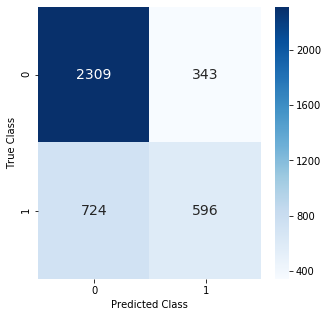

In [22]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def convert_prob_to_label(p):
  if p >=0.5:
    return 1
  return 0

y_pred = model.predict(padded_tweets_test, batch_size=1)
y_pred_bool = [convert_prob_to_label(p) for p in y_pred]
print(classification_report(Y_test.values, y_pred_bool))
results = confusion_matrix(Y_test.values, y_pred_bool)
# plt.figure(figsize = (5,5))
# sns.heatmap(results, annot=True,annot_kws={"size": 10}, fmt='g')
%matplotlib inline
plt.figure(figsize = (5,5))
ax = sns.heatmap(results, cmap="Blues", annot=True,annot_kws={"size": 14},fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('LSTM')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [24]:
f1_score(Y_test.values, y_pred_bool, average='macro')  

0.6699901070009028

#Biderectional LSTM

## Model creating

In [0]:
model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix_train], input_length=100, trainable=False)
model.add(e)
model.add(Bidirectional(LSTM(16, return_sequences=True)))
model.add(Bidirectional(LSTM(10)))
# model.add(Dense(16, activation='tanh'))

model.add(Dense(1, activation='sigmoid'))
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

In [26]:
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          4002300   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 32)           40576     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 20)                3440      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 4,046,337
Trainable params: 44,037
Non-trainable params: 4,002,300
_________________________________________________________________
None


## Train model

In [27]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',np.unique(Y_train), Y_train)
print(class_weights)

[0.74886878 1.50454545]


In [29]:
# fit the model
from keras.callbacks import EarlyStopping, ModelCheckpoint

# model.fit(padded_tweets_train, train_labels, epochs=50)
history = model.fit(padded_tweets_train, Y_train.values, epochs=10,class_weight=class_weights)

Epoch 1/10
9268/9268 [==============================] - 226s 24ms/step - loss: 0.5953 - acc: 0.6868
Epoch 2/10
9268/9268 [==============================] - 223s 24ms/step - loss: 0.5378 - acc: 0.7260
Epoch 3/10
9268/9268 [==============================] - 222s 24ms/step - loss: 0.5112 - acc: 0.7479
Epoch 4/10
9268/9268 [==============================] - 223s 24ms/step - loss: 0.4924 - acc: 0.7586
Epoch 5/10
9268/9268 [==============================] - 224s 24ms/step - loss: 0.4683 - acc: 0.7756
Epoch 6/10
9268/9268 [==============================] - 225s 24ms/step - loss: 0.4406 - acc: 0.7915
Epoch 7/10
9268/9268 [==============================] - 226s 24ms/step - loss: 0.4141 - acc: 0.8090
Epoch 8/10
9268/9268 [==============================] - 224s 24ms/step - loss: 0.3797 - acc: 0.8273
Epoch 9/10
9268/9268 [==============================] - 224s 24ms/step - loss: 0.3477 - acc: 0.8482
Epoch 10/10
9268/9268 [==============================] - 223s 24ms/step - loss: 0.3141 - acc: 0.8685

In [30]:
# loss, accuracy = model.evaluate(padded_tweets_train, Y_train.values)
loss, accuracy = model.evaluate(padded_tweets_train,  Y_train.values)
print('Accuracy: %f' % (accuracy*100))
# print(train_labels,Y_train)

9268/9268 [==============================] - 91s 10ms/step
Accuracy: 89.318084


## Predict using the model

In [31]:
y_pred = model.predict(padded_tweets_test, batch_size=128, verbose=1)

3972/3972 [==============================] - 10s 3ms/step


In [32]:
print(y_pred)

[[0.6841166 ]
 [0.3254791 ]
 [0.77431476]
 ...
 [0.63273466]
 [0.8581395 ]
 [0.05439764]]


              precision    recall  f1-score   support

           0       0.77      0.82      0.79      2652
           1       0.58      0.51      0.54      1320

    accuracy                           0.71      3972
   macro avg       0.67      0.66      0.67      3972
weighted avg       0.70      0.71      0.71      3972



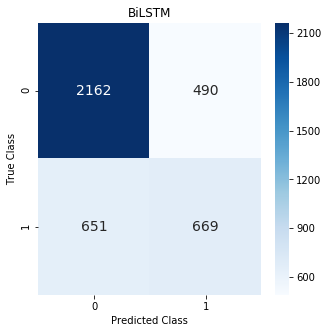

In [34]:
y_pred_bool = [convert_prob_to_label(p) for p in y_pred]
print(classification_report(Y_test.values, y_pred_bool))
results = confusion_matrix(Y_test.values, y_pred_bool)
# plt.figure(figsize = (5,5))
# sns.heatmap(results, annot=True,annot_kws={"size": 10}, fmt='g')
%matplotlib inline
plt.figure(figsize = (5,5))
plt.title("BiLSTM")
ax = sns.heatmap(results, cmap="Blues", annot=True,annot_kws={"size": 14},fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [0]:
print("F1 Score = " + str(f1_score(Y_test.values,predicted_labels,average='weighted')))

F1 Score = 0.6061498574115503
